In [1]:
# Set t for transmission and r for reflection

VNA_mode = 't'

In [2]:
import sys
sys.path.append('C:/QCodes drivers and scripts/Drivers')

from PLH250P_current_source_dummy import TTi
from PLH250P_current_source_TCP import current_set,power_up as current_source_on,power_down as current_source_off
current_source = TTi('TTi')

import VNA_Anritsu as VNA_Anritsu
vna= VNA_Anritsu.MS46522B('VNA', 'TCPIP::192.168.0.52',  init_s_params=False)
if VNA_mode == 't':
    vna.write(':CALCulate1:PARameter1:DEFine S21')
    vna.add_channel('S21')
elif VNA_mode == 'r':
    vna.write(':CALCulate1:PARameter1:DEFine S11')
    vna.add_channel('S11')

# from RS_SMB_100A import SMB100A
# MW_source_1_transmission = SMB100A('SMB100A_1', 'TCPIP0::192.168.0.53::inst0::INSTR')
# MW_source_2_transmission = SMB100A('SMB100A_2', 'TCPIP0::192.168.0.54::inst0::INSTR')

# from RS_FSQ import RS_FSQ
# RS_SA_transmission = RS_FSQ('RS_FSQ', 'TCPIP0::192.168.0.61::inst0::INSTR')

Connected to: Dummy corp current source 001 (serial:dummy 100, firmware:None) in 0.00s
Connected to: ANRITSU MS46522B (serial:1728106, firmware:V2019.12.1,V3.3.12) in 0.06s


In [3]:
import sys
import qcodes as qc
from qcodes.logger.logger import start_all_logging
import datetime
from qcodes.dataset.plotting import plot_dataset
import numpy as np
import matplotlib.pyplot as plt
#qcodes.config.subscription.default_subscribers = ["Plottr"]
from time import sleep

from pprint import pprint
import json

sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_bar import bar

In [4]:
import matplotlib
# %matplotlib notebook
%matplotlib inline

In [5]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\230118-20908-qcodes.log


In [6]:
#create a station
station = qc.Station()
station.add_component(vna)
station.add_component(current_source)
# station.add_component(MW_source_1_transmission)
# station.add_component(MW_source_2_transmission)
# station.add_component(RS_SA_transmission)
station.snapshot()
station.components

{'VNA': <MS46522B: VNA>, 'TTi': <TTi: TTi>}

In [7]:
# Load experiment details
experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment=json.loads(''.join(experiment))

user = experiment['details']['user']
# date = experiment['details']['date']
date = '-'.join(str(datetime.date.today()).split('-'))
description = experiment['details']['description']
cooldown = experiment['details']['cooldown']
database_name = date+"_"+'CD_'+cooldown+'_'+user+"_"+description
database_name
# database_name = '2021-07-12_CD_07_07_AR_ME_2_mode_squeezing'

#Create or Initialize the database
qc.initialise_or_create_database_at("D:/Data_QCodes/"+database_name)
qc.config.core.db_location

'D:/Data_QCodes/2023-01-18_CD_23_01_17_AR_GL_GC_squeezing_gen2'

In [8]:
device_ids = experiment['device_ids']
print(str(experiment['current_device']['current_device']))

B2


In [9]:
parameter_snap={}

# VNA
start_freq = 3
end_freq = 13
points_per_gigahz = 100
VNA_power = -30
IF_bandwidth = 200
Averages = 1
points_VNA=1+(end_freq-start_freq)*points_per_gigahz
points_VNA=int(points_VNA)
# points_VNA=5001
parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA,'VNA_mode':VNA_mode}

I = 0
parameter_snap['flux']={'I':I}

In [10]:
if VNA_mode == 't':
    
    vna.channels.S21.bandwidth(IF_bandwidth)
    vna.channels.S21.power(VNA_power)
    vna.channels.S21.avg(Averages)

    vna.channels.npts(points_VNA)
    vna.channels.start(start_freq*1e9)
    vna.channels.stop(end_freq*1e9)


    # Initialize devices and measurement
    vna.rf_on()
    vna.cont_meas_on()

    experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
    experiment = experiment_file.readlines()
    experiment = json.loads(''.join(experiment))
    switch_position = experiment['current_device']['current_device']

    exp_name = 'VNA Transmission'
    sample_name = str(switch_position) + ' : ' + device_ids[switch_position]
    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)

    meas = qc.Measurement(exp=exp, station=station) 
    meas.register_parameter(vna.channels.S21.trace_mag_phase) 
    meas.write_period = 2

    with meas.run() as datasaver:
        get_v = vna.channels.S21.trace_mag_phase.get()
        datasaver.add_result((vna.channels.S21.trace_mag_phase, get_v))

    id_num=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id_num).add_metadata('parameter_snap',json.dumps(parameter_snap))

Starting experimental run with id: 2. 


In [23]:
if VNA_mode == 'r':
    
    vna.channels.S11.bandwidth(IF_bandwidth)
    vna.channels.S11.power(VNA_power)
    vna.channels.S11.avg(Averages)
    
    vna.channels.npts(points_VNA)
    vna.channels.start(start_freq*1e9)
    vna.channels.stop(end_freq*1e9)


    # Initialize devices and measurement
    vna.rf_on()
    vna.cont_meas_on()

    experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.txt','r')
    experiment = experiment_file.readlines()
    experiment = json.loads(''.join(experiment))
    switch_position = experiment['current_device']['current_device']

    exp_name = 'VNA Reflection'
    sample_name = device_ids[switch_position]
    exp=qc.load_or_create_experiment(experiment_name=exp_name,
                              sample_name=sample_name)

    meas = qc.Measurement(exp=exp, station=station) 
    meas.register_parameter(vna.channels.S11.trace_mag_phase) 
    meas.write_period = 2

    with meas.run() as datasaver:
        get_v = vna.channels.S11.trace_mag_phase.get()
        datasaver.add_result((vna.channels.S11.trace_mag_phase, get_v))

    id_num=datasaver.dataset.run_id
    qc.load_by_run_spec( captured_run_id=id_num).add_metadata('parameter_snap',json.dumps(parameter_snap))

In [11]:
captured_run_id = id_num

dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
print(dataset)

exp_name = dataset.exp_name
sample_name = dataset.sample_name
meta = json.loads(dataset.get_metadata('parameter_snap'))
start_freq = meta['vna']['start_freq']
end_freq = meta['vna']['end_freq']
points_per_gigahz = meta['vna']['points_per_gigahz']
VNA_power =  meta['vna']['VNA_power']
VNA_mode =  meta['vna']['VNA_mode']
# print(points_per_gigahz*(end_freq-start_freq))
if VNA_mode == 't':
    
    mag_t = dataset.get_parameter_data('VNA_S21_magnitude')['VNA_S21_magnitude']['VNA_S21_magnitude']
    VNA_S21_phase_t = dataset.get_parameter_data('VNA_S21_phase')['VNA_S21_phase']['VNA_S21_phase']
    freq_data_t = dataset.get_parameter_data('VNA_S21_S21_frequency')['VNA_S21_S21_frequency']['VNA_S21_S21_frequency'][:int(points_per_gigahz*(end_freq-start_freq))+1]*1e-9
    
elif VNA_mode == 'r':
    
    mag_r = dataset.get_parameter_data('VNA_S21_magnitude')['VNA_S21_magnitude']['VNA_S21_magnitude']
    VNA_S21_phase_r = dataset.get_parameter_data('VNA_S21_phase')['VNA_S21_phase']['VNA_S21_phase']
    freq_data_r = dataset.get_parameter_data('VNA_S11_S11_frequency')['VNA_S11_S11_frequency']['VNA_S11_S11_frequency'][:points_per_gigahz*(end_freq-start_freq)+1]*1e-9

results #2@D:\Data_QCodes\2023-01-18_CD_23_01_17_AR_GL_GC_squeezing_gen2
------------------------------------------------------------------------
VNA_S21_S21_frequency - numeric
VNA_S21_magnitude - numeric
VNA_S21_phase - numeric


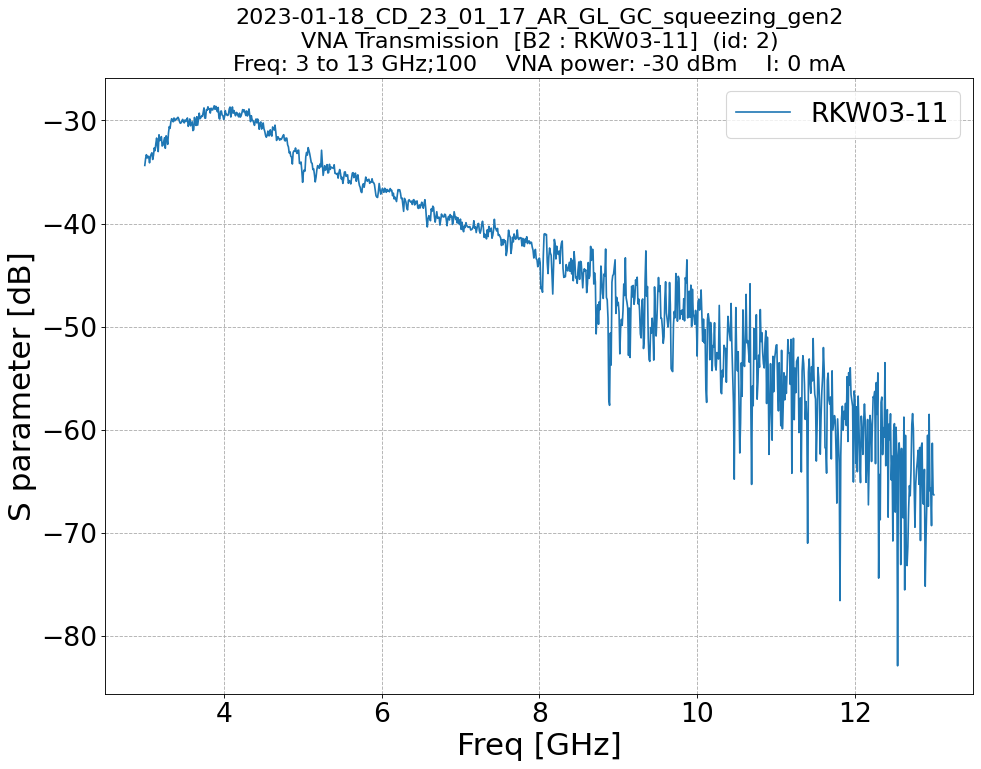

In [12]:
# plot_title = database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id: '+str(captured_run_id) + '&'+str(captured_run_id2)
# plot_title+=')\nFreq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)+'    VNA power '+str(VNA_power)+' dBm    flux: '+str(I)+' mA'
plot_title = database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id: '+str(captured_run_id) +')'
plot_title+='\nFreq: '+str(start_freq)+' to '+str(end_freq)+' GHz;'+str(points_per_gigahz)+'    VNA power: '+str(VNA_power)+' dBm    I: '+str(I)+' mA'

fig = plt.figure(figsize=(14, 10), dpi= 80) #facecolor='w', edgecolor='k'

x_label='Freq [GHz]'
y_label='S parameter [dB]'

plt.rc('axes', labelsize=10*2)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12*2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12*2)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

if VNA_mode == 't':
    plt.plot(freq_data_t,mag_t,label=device_ids[switch_position])
    # plt.plot(freq_data_t_aux,mag_t_aux,label='PCB')
elif VNA_mode == 'r':
    plt.plot(freq_data_r,mag_r,label='reflection')
    
plt.xlabel(x_label, size=14*2)
plt.ylabel(y_label, size=14*2)
plt.title(plot_title, size=20)

# plt.ylim(-35,0)

plt.legend(fontsize = 12*2)
# plt.show()
# fig.show()